In [ ]:
#import library
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
def crop_resize_clean(path_picture):
    print(path_picture)
    #path = str(path_picture)
    #print(path)
    image = cv2.imread(path_picture)
    #plt.imshow(image)
    # Détection d'objet
    img_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    ret, thresh = cv2.threshold(img_grey, thresh=40, maxval=255, type=0)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    max_numb = 0
    for contour in contours:
        if len(contour) > max_numb:
            max_numb = len(contour)
            cnt = contour
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    #print(box)
    cv2.drawContours(image, [box], 0, (0, 0, 255), 2)

    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Rognage et redimensionnement autour de l'objet détecté

    height = 106
    width = 106
    dim = (width, height)

    img = cv2.imread(path_picture)
    img_crop = img[y-int(h/2):y+int(3*h/2), x-int(w/3):x+int(4*w/3)]

    resized = cv2.resize(img[y-int(h/2):y+int(3*h/2), x-int(w/3):x+int(4*w/3)], dim, interpolation=cv2.INTER_AREA)

    # Nettoyage de l'image redimensionnée

    blur = cv2.GaussianBlur(resized, (5, 5), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

    ret, markers = cv2.connectedComponents(thresh)

    #markers = markers + 1

    markers = cv2.watershed(blur, markers)

    center = markers[round(img_crop.shape[0]/2), round(img_crop.shape[1]/2)]

    masque = np.array(markers)
    blur2 = blur.copy()
    masque[:,:] = 0
    masque[markers == center] = 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
    masque = cv2.dilate(masque.astype(np.uint8), kernel, iterations = 1)
    masque = cv2.blur(masque.astype(float), (5,5))

    for i in range(3):
        blur2[:,:,i] = (masque*blur[:,:,i]/255.0).astype(np.uint8)

    return blur2

In [4]:
def resize_image(path_picture):
    image = cv2.imread(path_picture)
    height = 106
    width = 106
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized

In [5]:
def clean_image(resized):
    blur = cv2.GaussianBlur(resized, (5, 5), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

    ret, markers = cv2.connectedComponents(thresh)
    markers = cv2.watershed(blur, markers)

    center = markers[round(resized.shape[0]/2), round(resized.shape[1]/2)]

    masque = np.array(markers)
    blur2 = blur.copy()
    masque[:,:] = 0
    masque[markers == center] = 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
    masque = cv2.dilate(masque.astype(np.uint8), kernel, iterations = 1)
    masque = cv2.blur(masque.astype(float), (5,5))

    for i in range(3):
        blur2[:,:,i] = (masque*blur[:,:,i]/255.0).astype(np.uint8)

    return blur2   

In [6]:
import pandas as pd
from pandas import read_csv
Y = pd.read_csv('data_galaxy_zoo/training_solutions_rev1/training_solutions_rev1.csv').iloc[:1000,:4]
Y

,GalaxyID,Class1.1,Class1.2,Class1.3
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161
...,...,...,...,...
995,115033,0.425255,0.574745,0.000000
996,115042,0.622582,0.349007,0.028411
997,115051,0.847363,0.152637,0.000000
998,115073,0.483536,0.465258,0.051206


In [7]:
dir = 'data_galaxy_zoo/images_training_rev1/'
id = str(Y['GalaxyID'][1])
path = dir + id + '.jpg'
path

'data_galaxy_zoo/images_training_rev1/100023.jpg'

In [8]:
X = []
for i in range(len(Y.head(1000))):
    dir = 'data_galaxy_zoo/images_training_rev1/'
    id = str(Y['GalaxyID'][i])
    path = dir + id + '.jpg'
    image = clean_image(resize_image(path)).astype(np.float32)
    X.append(image)

In [9]:
X = np.asarray(X)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y.head(1000).iloc[:,:], test_size=0.3, random_state=42)

In [11]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(700, 106, 106, 3)
(300, 106, 106, 3)
(700, 4)
(300, 4)


In [12]:
Y_train

,GalaxyID,Class1.1,Class1.2,Class1.3
541,107688,0.569419,0.430581,0.000000
440,106471,0.317754,0.682246,0.000000
482,107106,0.564946,0.403924,0.031130
422,106165,0.262619,0.722361,0.015021
778,111622,0.039011,0.957130,0.003859
...,...,...,...,...
106,101548,0.750104,0.155924,0.093971
270,103907,0.549540,0.435993,0.014467
860,112843,0.457719,0.525546,0.016735
435,106390,0.024197,0.964936,0.010867


In [13]:
Y_train_id = Y_train['GalaxyID']
Y_train = Y_train.drop(['GalaxyID'], axis=1)
Y_val_id = Y_val['GalaxyID']
Y_val = Y_val.drop(['GalaxyID'], axis=1)

In [14]:
Y_val

,Class1.1,Class1.2,Class1.3
521,0.000000,0.980000,0.020000
737,0.437450,0.536271,0.026279
740,0.371623,0.555417,0.072960
660,0.284836,0.685696,0.029468
411,0.698037,0.301963,0.000000
...,...,...,...
468,0.305342,0.670223,0.024435
935,0.147226,0.848798,0.003977
428,0.646201,0.321552,0.032248
7,0.687783,0.288344,0.023873


In [15]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling1D
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

# Normalize the images.
#X_train = (X_train / 255) - 0.5
#X_valid = (X_valid / 255) - 0.5

# Reshape the images.
#X_train = np.expand_dims(X_train, axis=3)
#X_valid = np.expand_dims(X_valid, axis=3)


# Build the model.
model = Sequential([
  Conv2D(8, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  Conv2D(8, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  MaxPooling2D(pool_size=(2,2), strides=(2,2)),
  Dropout(0.4),

  Conv2D(16, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  Conv2D(16, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  MaxPooling2D(pool_size=(2,2), strides=(2,2)),
  Dropout(0.4),
    
  Conv2D(32, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  Conv2D(32, (3,3), strides=1, input_shape=(106, 106, 3), activation='elu'),
  MaxPooling2D(pool_size=(2,2), strides=(2,2)),
  Dropout(0.4),
  
  Conv2D(32, (1,1), strides=1, input_shape=(106, 106, 3), activation='elu'),
  Dropout(0.4),  
    
  #Conv2D(10, (1,1), strides=1, input_shape=(64, 64, 1), activation='elu'),  
  
  Flatten(),
  Dense(3, activation='softmax'),  
    
])

# Compile the model.
learning_rate = 0.01
model.compile(
  'RMSprop',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
  #optimizer=SGD(lr=learning_rate)
)

#callbacks = [EarlyStopping(monitor='val_accuracy', patience=5)]

# Train the model.
history = model.fit(
  X_train,
  Y_train,
  epochs=50,
  #callbacks=callbacks,
  validation_data=(X_val, Y_val),
)

Using TensorFlow backend.


Train on 700 samples, validate on 300 samples
Epoch 1/50
700/700 [==============================] - 11s 16ms/step - loss: 1.5290 - accuracy: 0.5414 - val_loss: 0.9263 - val_accuracy: 0.5567
Epoch 2/50
700/700 [==============================] - 11s 16ms/step - loss: 0.8877 - accuracy: 0.5871 - val_loss: 0.8682 - val_accuracy: 0.5967
Epoch 3/50
700/700 [==============================] - 11s 15ms/step - loss: 0.8422 - accuracy: 0.6200 - val_loss: 0.7589 - val_accuracy: 0.6800
Epoch 4/50
700/700 [==============================] - 10s 15ms/step - loss: 0.8065 - accuracy: 0.6571 - val_loss: 0.7760 - val_accuracy: 0.6467
Epoch 5/50
700/700 [==============================] - 10s 14ms/step - loss: 0.7846 - accuracy: 0.6643 - val_loss: 0.7502 - val_accuracy: 0.7100
Epoch 6/50
700/700 [==============================] - 10s 14ms/step - loss: 0.7659 - accuracy: 0.7000 - val_loss: 0.7832 - val_accuracy: 0.6233
Epoch 7/50
700/700 [==============================] - 10s 14ms/step - loss: 0.7637 - accur

In [16]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 104, 104, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 102, 102, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 51, 51, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 51, 51, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 49, 49, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 16)       

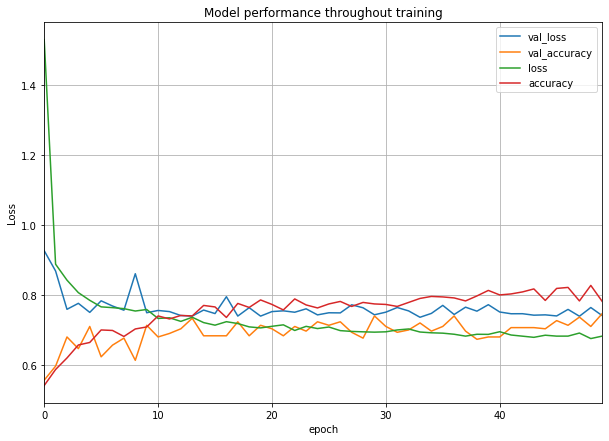

In [17]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.title('Model performance throughout training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
Y_predict = model.predict(X_val)

In [19]:
Y_predict

array([[0.34290054, 0.64981216, 0.0072872 ],
       [0.6701075 , 0.29735938, 0.03253316],
       [0.31861693, 0.66371006, 0.01767305],
       [0.31454727, 0.67359835, 0.01185433],
       [0.57999057, 0.3913193 , 0.02869019],
       [0.4457908 , 0.53909725, 0.01511191],
       [0.18702365, 0.8026743 , 0.01030203],
       [0.6978633 , 0.2618741 , 0.04026261],
       [0.575084  , 0.38505358, 0.03986241],
       [0.5339001 , 0.4359764 , 0.03012353],
       [0.66603833, 0.31360525, 0.02035638],
       [0.6916309 , 0.2702536 , 0.03811552],
       [0.2299381 , 0.7525913 , 0.01747059],
       [0.47038412, 0.5174234 , 0.01219256],
       [0.261754  , 0.72951055, 0.00873546],
       [0.6958487 , 0.2860455 , 0.01810578],
       [0.5196735 , 0.46446657, 0.01585984],
       [0.1840477 , 0.8080867 , 0.00786568],
       [0.29780057, 0.68529975, 0.01689966],
       [0.3049052 , 0.68740827, 0.00768657],
       [0.28460583, 0.69325656, 0.02213766],
       [0.12761296, 0.86744314, 0.00494386],
       [0.

In [20]:
Y_val = pd.concat([Y_val_id, Y_val], axis=1)

In [21]:
Y_val['Class'] = Y_val.iloc[:,1:4].idxmax(axis = 1)

In [22]:
Y_val

,GalaxyID,Class1.1,Class1.2,Class1.3,Class
521,107555,0.000000,0.980000,0.020000,Class1.2
737,110923,0.437450,0.536271,0.026279,Class1.2
740,111022,0.371623,0.555417,0.072960,Class1.2
660,109629,0.284836,0.685696,0.029468,Class1.2
411,106018,0.698037,0.301963,0.000000,Class1.1
...,...,...,...,...,...
468,106885,0.305342,0.670223,0.024435,Class1.2
935,113987,0.147226,0.848798,0.003977,Class1.2
428,106230,0.646201,0.321552,0.032248,Class1.1
7,100128,0.687783,0.288344,0.023873,Class1.1


In [23]:
df = pd.DataFrame(Y_predict, columns=['Class1.1','Class1.2','Class1.3'])
df

,Class1.1,Class1.2,Class1.3
0,0.342901,0.649812,0.007287
1,0.670107,0.297359,0.032533
2,0.318617,0.663710,0.017673
3,0.314547,0.673598,0.011854
4,0.579991,0.391319,0.028690
...,...,...,...
295,0.441393,0.546999,0.011608
296,0.122090,0.870821,0.007089
297,0.577558,0.392697,0.029745
298,0.688910,0.278996,0.032094


In [24]:
df['Class'] = df.iloc[:,1:4].idxmax(axis = 1)
df

,Class1.1,Class1.2,Class1.3,Class
0,0.342901,0.649812,0.007287,Class1.2
1,0.670107,0.297359,0.032533,Class1.2
2,0.318617,0.663710,0.017673,Class1.2
3,0.314547,0.673598,0.011854,Class1.2
4,0.579991,0.391319,0.028690,Class1.2
...,...,...,...,...
295,0.441393,0.546999,0.011608,Class1.2
296,0.122090,0.870821,0.007089,Class1.2
297,0.577558,0.392697,0.029745,Class1.2
298,0.688910,0.278996,0.032094,Class1.2


In [25]:
predict_ok = []
true = 0
false = 0
for i in df:
    if df['Class'][i] == Y_val['Class'][i]:
        p = True 
        true += 1    
    else:
        p = False
        false += 1
    predict_ok.append(p)
                
predict_ok
print('Nombres de prédictions Valide :',true)
print('Nombres de mauvaise prédictions :',false)

KeyError: 'Class1.1'